In [49]:
from functions import *
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import shap
from sklearn.model_selection import train_test_split
from collections import Counter

## Data Preprocessing

In [50]:
path_1 = "/Users/rajwaghela/Library/CloudStorage/GoogleDrive-rajwaghela4244@gmail.com/My Drive/Thesis/Practical/Data/Vectors/sem1.csv"
path_2 = "/Users/rajwaghela/Library/CloudStorage/GoogleDrive-rajwaghela4244@gmail.com/My Drive/Thesis/Practical/Data/Vectors/sem2.csv"
path_3 = "/Users/rajwaghela/Library/CloudStorage/GoogleDrive-rajwaghela4244@gmail.com/My Drive/Thesis/Practical/Data/Vectors/sem3.csv"
path_4 = "/Users/rajwaghela/Library/CloudStorage/GoogleDrive-rajwaghela4244@gmail.com/My Drive/Thesis/Practical/Data/Vectors/sem4.csv"

BHT_1 = pd.read_csv(path_1, sep=';')
BHT_2 = pd.read_csv(path_2, sep=',')
BHT_3 = pd.read_csv(path_3, sep=',')
BHT_4 = pd.read_csv(path_4, sep=',')

In [51]:
BHT_1 = BHT_1.drop(columns=['Unnamed: 0']).rename(columns={'label': 'status'})
BHT_2 = BHT_2.drop(columns=['Unnamed: 0']).rename(columns={'label': 'status'})
BHT_3 = BHT_3.drop(columns=['Unnamed: 0']).rename(columns={'label': 'status'})
BHT_4 = BHT_4.drop(columns=['Unnamed: 0']).rename(columns={'label': 'status'})

In [52]:
BHT_1 = BHT_1[BHT_1['no_passed_courses_1']<=6]
BHT_2 = BHT_2[(BHT_2['no_passed_courses_2']<=12) & (BHT_2['no_passed_courses_1']<=6)]
BHT_3 = BHT_3[(BHT_3['no_passed_courses_2']<=12) & (BHT_3['no_passed_courses_1']<=6)]
BHT_4 = BHT_4[(BHT_4['no_passed_courses_2']<=12) & (BHT_4['no_passed_courses_1']<=6)]


In [53]:
### swaping values
# after swaping, '1' is -> 'dropout' & '0'a is ->'graduate'
BHT_1['status'] = BHT_1['status'].replace([0, 1], [1, 0])
BHT_2['status'] = BHT_2['status'].replace([0, 1], [1, 0])
BHT_3['status'] = BHT_3['status'].replace([0, 1], [1, 0])
BHT_4['status'] = BHT_4['status'].replace([0, 1], [1, 0])

In [54]:
features_bht1 = BHT_1.columns[1:-1]
features_bht2 = BHT_2.columns[1:-1]
features_bht3 = BHT_3.columns[1:-1]
features_bht4 = BHT_4.columns[1:-1]

### Search Space / Param Grid 

In [57]:
from hyperopt import *
search_space = {
    'n_estimators': hp.choice('n_estimators', np.arange(5, 50, 5)),  # Smaller number of trees for small datasets
    'max_depth': hp.choice('max_depth', np.arange(3, 20, 1)),  # Limit depth to prevent overfitting
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),  # Control the number of features considered
    'min_samples_split': hp.uniform('min_samples_split', 0.05, 1),  # Increase to avoid splitting on very small samples
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.05, 1),  # Ensure min_samples_leaf is an integer
    'bootstrap': hp.choice('bootstrap', [True]),  # Set bootstrap to True to avoid overfitting
    'criterion': hp.choice('criterion', ['gini', 'entropy']),  # Criterion for splitting nodes
    'oob_score': hp.choice('oob_score', [True, False]),  # Out-of-bag samples estimation for validation
    'class_weight': 'balanced',
    'ccp_alpha': hp.loguniform('ccp_alpha', -7,0)
}


## BHT semester 1

In [58]:
# Count occurrences of each unique value in the 'status' column
counter_1 = Counter(BHT_1['status'])
print(f'Quantity of Drop Out and Degree in THL-1: \n 1: {counter_1[1]} | 0: {counter_1[0]}')
hpo = ModelTrainer(random_state=48)
x, y = hpo.split_data(BHT_1, features_bht1)

Quantity of Drop Out and Degree in THL-1: 
 1: 160 | 0: 96


------------------------------------- Fold 1 --------------------------------------------------
100%|██████████| 10/10 [00:01<00:00,  7.47trial/s, best loss: -0.7578782051282051]

Confusion Matrix
	                 predicted 0     predicted 1
	 actual 0            14               06
	 actual 1            10               22

Model parameters:
{'bootstrap': True, 'ccp_alpha': 0.003223995203333891, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 13, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.08376235499263074, 'min_samples_split': 0.32155239198459296, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 25, 'n_jobs': None, 'oob_score': False, 'random_state': 48, 'verbose': 0, 'warm_start': False}

Balanced acc.: 69.37500%
Validation accuracy.: 69.23077%
Sensitivity score (for 1): 68.75000%
Specificity score (for 0): 70.00000%
F1 score.: 73.33333%
False prediction: 30.76923%

--

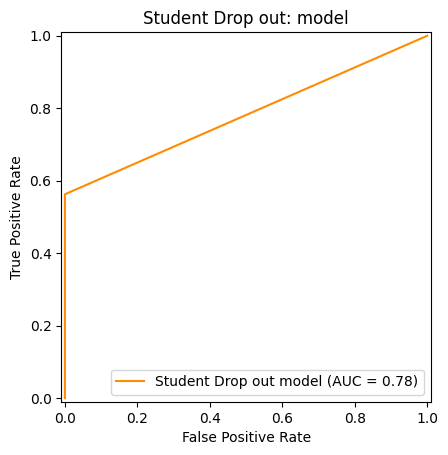

In [59]:
model_1, feature_importance_1 = hpo.cross_validation_hpo(
    x=x, y=y,
    search_space=search_space, 
    folds=5,
    algo='rf',
    )

In [60]:
feature_importance_1

,Feature,Importance
0,no_passed_courses_1,0.511362
3,avg_grade_all_courses_1,0.302897
2,no_of_unattempted_courses_1,0.156011
1,no_of_failed_courses_1,0.029730


#### Shap analysis

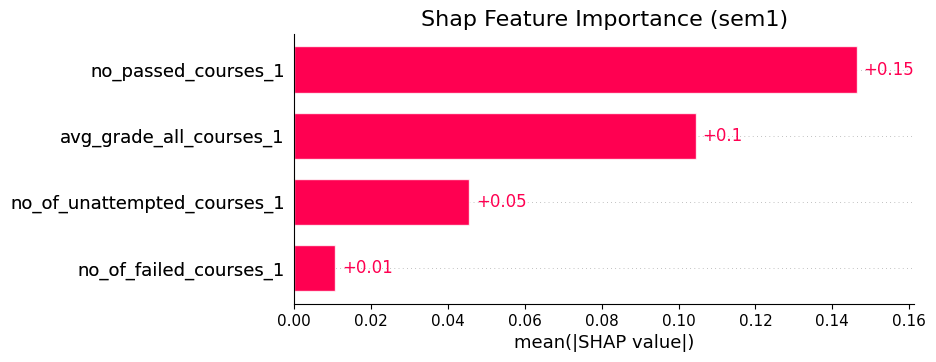

In [61]:
## Shap Global explainations
import shap
explainer = shap.TreeExplainer(model_1['model'], model_1['x_train'])
shap_values = explainer(model_1['x_test'])

plt.title('Shap Feature Importance (sem1)', fontsize=16)
shap.plots.bar(shap_values[...,1])

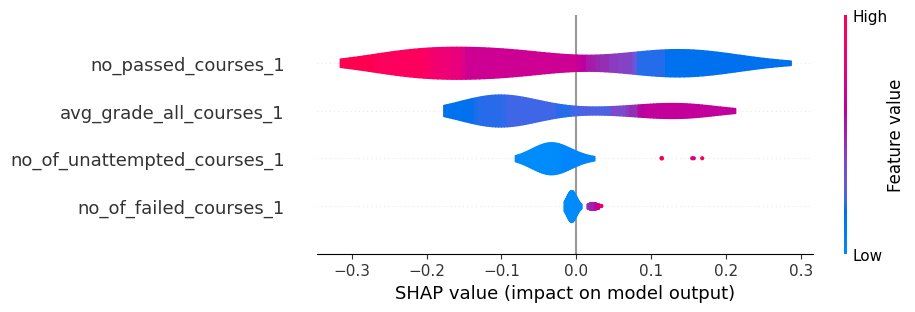

In [62]:
shap.plots.violin(shap_values[...,1], show=True)

In [63]:
## Local explainations
shap.initjs()
shap.force_plot(shap_values[...,1], link='logit')

In [64]:
hpo.plot_shap_force(model=model_1, shap_values=shap_values, student_index=5, link='logit', model_name='dt') 

Student index 5 grades:
                             grades
no_passed_courses_1             6.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         1.5
Status: 0, Prediction: [0], Probability [0]: 0.829, Probability [1]: 0.171


In [65]:
hpo.plot_shap_force(model=model_1, shap_values=shap_values, student_index=9, link='logit', model_name='dt') 

Student index 9 grades:
                             grades
no_passed_courses_1             4.0
no_of_failed_courses_1          1.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         3.1
Status: 1, Prediction: [1], Probability [0]: 0.398, Probability [1]: 0.602


In [66]:
hpo.plot_shap_force(model=model_1, shap_values=shap_values, student_index=35, link='logit', model_name='dt') 

Student index 35 grades:
                             grades
no_passed_courses_1             2.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         1.2
Status: 1, Prediction: [1], Probability [0]: 0.493, Probability [1]: 0.507


## BHT semester 2 

In [67]:
# Count occurrences of each unique value in the 'status' column
counter_2 = Counter(BHT_2['status'])
print(f'Quantity of Drop Out and Degree in THL-2: \n 1: {counter_2[1]} | 0: {counter_2[0]}')
hpo2 = ModelTrainer(random_state=64)
x2, y2 = hpo2.split_data(BHT_2, features_bht2)

Quantity of Drop Out and Degree in THL-2: 
 1: 102 | 0: 95


------------------------------------- Fold 1 --------------------------------------------------
100%|██████████| 10/10 [00:01<00:00,  8.52trial/s, best loss: -0.6951715686274509]

Confusion Matrix
	                 predicted 0     predicted 1
	 actual 0            12               07
	 actual 1            08               13

Model parameters:
{'bootstrap': True, 'ccp_alpha': 0.0770492746231228, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.2735640128538301, 'min_samples_split': 0.2699842535852674, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 30, 'n_jobs': None, 'oob_score': True, 'random_state': 64, 'verbose': 0, 'warm_start': False}

Balanced acc.: 62.53133%
Validation accuracy.: 62.50000%
Sensitivity score (for 1): 61.90476%
Specificity score (for 0): 63.15789%
F1 score.: 63.41463%
False prediction: 37.50000%

-----

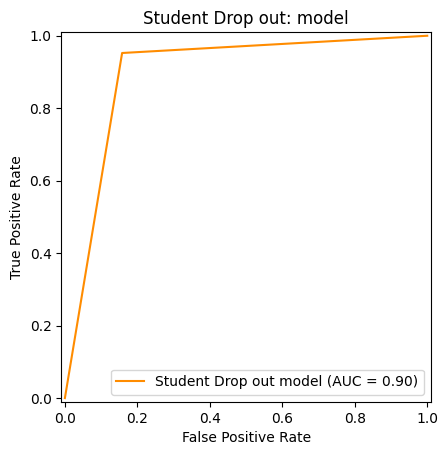

In [68]:
models_2, feature_importance_2 = hpo2.cross_validation_hpo(
    x=x2, y=y2,
    search_space=search_space, 
    folds=5,
    algo='rf'
    )

In [69]:
feature_importance_2

,Feature,Importance
0,no_passed_courses_2,0.555556
3,avg_grade_all_courses_2,0.222222
7,avg_grade_all_courses_1,0.222222
1,no_of_failed_courses_2,0.000000
2,no_of_unattempted_courses_2,0.000000
4,no_passed_courses_1,0.000000
5,no_of_failed_courses_1,0.000000
6,no_of_unattempted_courses_1,0.000000


#### Shap analysis

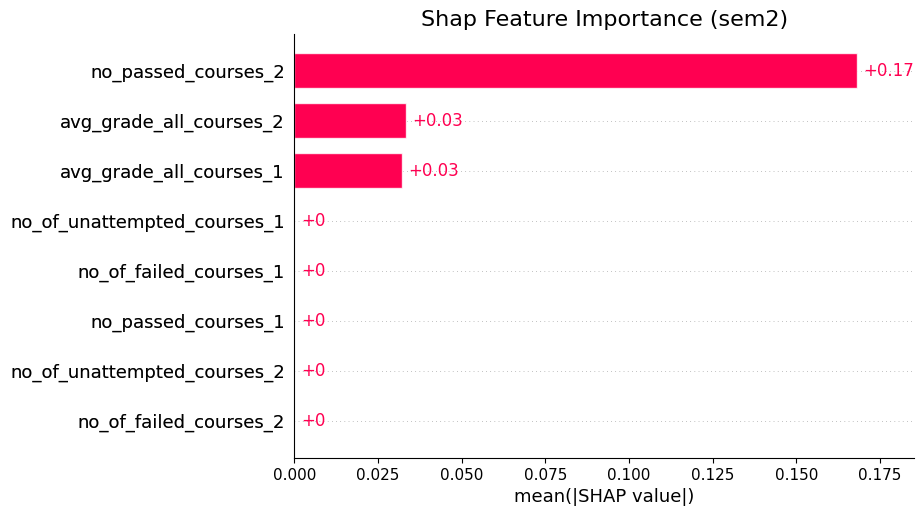

In [70]:
## Shap Global explainations
import shap
explainer2 = shap.TreeExplainer(models_2['model'], models_2['x_train'])
shap_values2 = explainer2(models_2['x_test'])

plt.title('Shap Feature Importance (sem2)', fontsize=16)
shap.plots.bar(shap_values2[...,1])

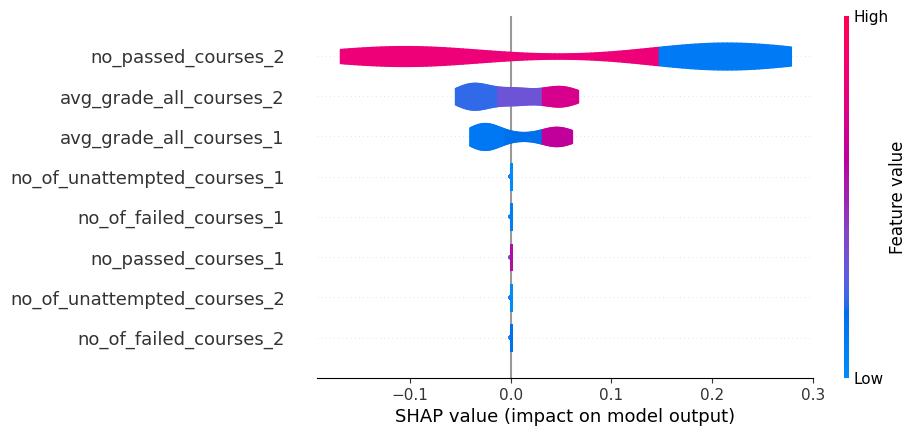

In [71]:
shap.plots.violin(shap_values2[...,1], show=True)

In [72]:
## Local explainations
shap.initjs()
shap.force_plot(shap_values2[...,1], link='logit')

In [73]:
hpo2.plot_shap_force(model=models_2, shap_values=shap_values2, student_index=14, link='logit', model_name='dt')

Student index 14 grades:
                             grades
no_passed_courses_2             2.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         3.8
no_passed_courses_1             1.0
no_of_failed_courses_1          1.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         3.5
Status: 1, Prediction: [1], Probability [0]: 0.190, Probability [1]: 0.810


In [74]:
hpo2.plot_shap_force(model=models_2, shap_values=shap_values2, student_index=6, link='logit', model_name='dt')

Student index 6 grades:
                             grades
no_passed_courses_2             4.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         2.3
no_passed_courses_1             4.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         2.0
Status: 0, Prediction: [0], Probability [0]: 0.627, Probability [1]: 0.373


In [75]:
hpo2.plot_shap_force(model=models_2, shap_values=shap_values2, student_index=3, link='logit', model_name='dt')

Student index 3 grades:
                             grades
no_passed_courses_2             6.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         1.8
no_passed_courses_1             6.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         1.6
Status: 0, Prediction: [0], Probability [0]: 0.670, Probability [1]: 0.330


In [76]:
hpo2.plot_shap_force(model=models_2, shap_values=shap_values2, student_index=7, link='logit', model_name='dt')

Student index 7 grades:
                             grades
no_passed_courses_2             6.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         2.4
no_passed_courses_1             6.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         3.3
Status: 0, Prediction: [0], Probability [0]: 0.555, Probability [1]: 0.445


## BHT semester 3

In [77]:
# Count occurrences of each unique value in the 'status' column
counter_3 = Counter(BHT_3['status'])
print(f'Quantity of Drop Out and Degree in THL-1: \n 1: {counter_3[1]} | 0: {counter_3[0]}')
hpo3 = ModelTrainer(random_state=69)
x3, y3 = hpo3.split_data(BHT_3, features_bht3)

Quantity of Drop Out and Degree in THL-1: 
 1: 71 | 0: 95


------------------------------------- Fold 1 --------------------------------------------------
100%|██████████| 10/10 [00:01<00:00,  6.75trial/s, best loss: -0.8397727272727273]

Confusion Matrix
	                 predicted 0     predicted 1
	 actual 0            18               01
	 actual 1            01               14

Model parameters:
{'bootstrap': True, 'ccp_alpha': 0.0016931534875268964, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 13, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.19862566278050675, 'min_samples_split': 0.5986156477925579, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 40, 'n_jobs': None, 'oob_score': False, 'random_state': 69, 'verbose': 0, 'warm_start': False}

Balanced acc.: 94.03509%
Validation accuracy.: 94.11765%
Sensitivity score (for 1): 93.33333%
Specificity score (for 0): 94.73684%
F1 score.: 93.33333%
False prediction: 5.88235%

---

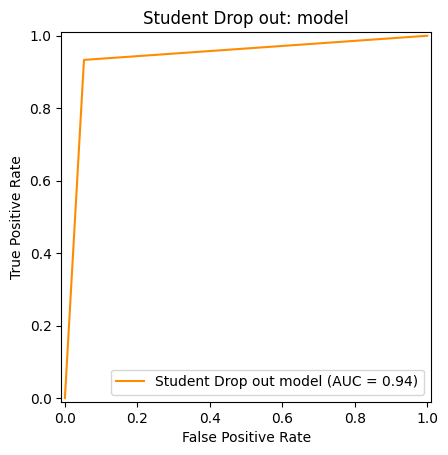

In [78]:
models_3, feature_importance_3 = hpo3.cross_validation_hpo(
    x=x3, y=y3,
    search_space=search_space, 
    folds=5,
    algo='rf'
    )

In [79]:
feature_importance_3

,Feature,Importance
0,no_passed_courses_3,0.321429
7,avg_grade_all_courses_2,0.214286
4,no_passed_courses_2,0.142857
11,avg_grade_all_courses_1,0.142857
8,no_passed_courses_1,0.107143
3,avg_grade_all_courses_3,0.071429
1,no_of_failed_courses_3,0.000000
2,no_of_unattempted_courses_3,0.000000
5,no_of_failed_courses_2,0.000000
6,no_of_unattempted_courses_2,0.000000


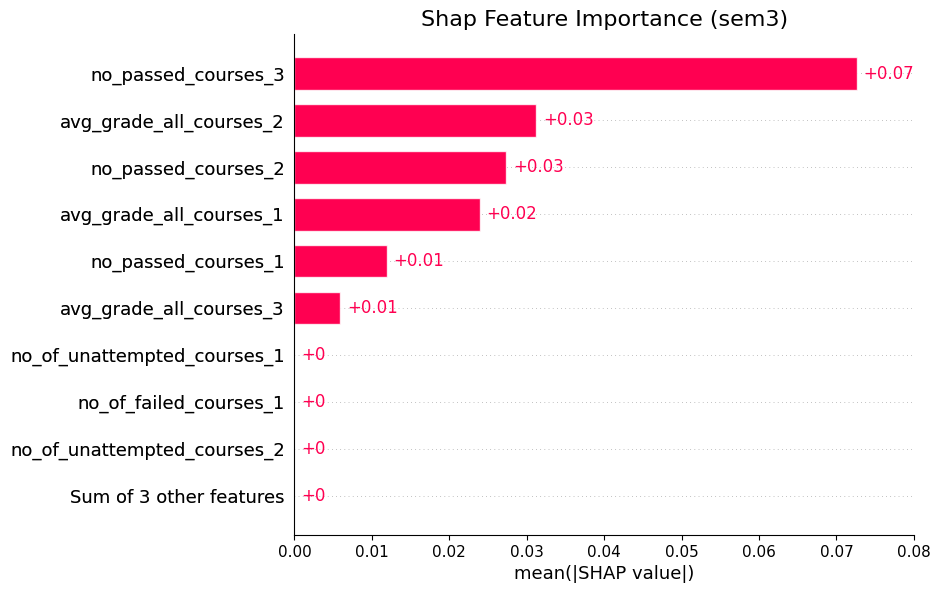

In [80]:
## Shap Global explainations
import shap
explainer3 = shap.TreeExplainer(models_3['model'], models_3['x_train'])
shap_values3 = explainer3(models_3['x_test'])

plt.title('Shap Feature Importance (sem3)', fontsize=16)
shap.plots.bar(shap_values3[..., 1])

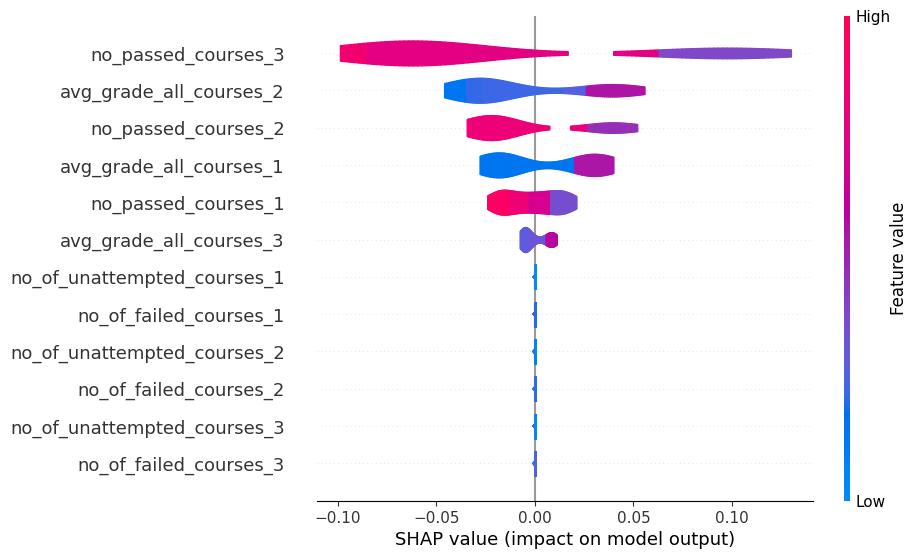

In [81]:
shap.plots.violin(shap_values3[..., 1], show=True)

In [82]:
## Local explainations
shap.initjs()
shap.force_plot(shap_values3[..., 1], link='identity')

In [83]:
hpo3.plot_shap_force(model=models_3, shap_values=shap_values3, student_index=1, link='identity', model_name='dt')

Student index 1 grades:
                             grades
no_passed_courses_3             0.0
no_of_failed_courses_3          2.0
no_of_unattempted_courses_3     0.0
avg_grade_all_courses_3         5.0
no_passed_courses_2             0.0
no_of_failed_courses_2          3.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         5.0
no_passed_courses_1             3.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         3.3
Status: 1, Prediction: [1], Probability [0]: 0.287, Probability [1]: 0.713


In [84]:
hpo3.plot_shap_force(model=models_3, shap_values=shap_values3, student_index=4, link='identity', model_name='dt')

Student index 4 grades:
                             grades
no_passed_courses_3             0.0
no_of_failed_courses_3          1.0
no_of_unattempted_courses_3     0.0
avg_grade_all_courses_3         5.0
no_passed_courses_2             0.0
no_of_failed_courses_2          2.0
no_of_unattempted_courses_2     2.0
avg_grade_all_courses_2         5.0
no_passed_courses_1             2.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         3.8
Status: 1, Prediction: [1], Probability [0]: 0.276, Probability [1]: 0.724


In [85]:
hpo3.plot_shap_force(model=models_3, shap_values=shap_values3, student_index=14, link='identity', model_name='dt')

Student index 14 grades:
                             grades
no_passed_courses_3             5.0
no_of_failed_courses_3          1.0
no_of_unattempted_courses_3     1.0
avg_grade_all_courses_3         3.3
no_passed_courses_2             6.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         2.0
no_passed_courses_1             5.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         2.8
Status: 0, Prediction: [0], Probability [0]: 0.606, Probability [1]: 0.394


In [86]:
hpo3.plot_shap_force(model=models_3, shap_values=shap_values3, student_index=24, link='identity', model_name='dt')

Student index 24 grades:
                             grades
no_passed_courses_3             5.0
no_of_failed_courses_3          1.0
no_of_unattempted_courses_3     0.0
avg_grade_all_courses_3         2.6
no_passed_courses_2             6.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         2.3
no_passed_courses_1             6.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         2.1
Status: 0, Prediction: [0], Probability [0]: 0.651, Probability [1]: 0.349


## BHT semester 4

In [87]:
# Count occurrences of each unique value in the 'status' column
counter_4 = Counter(BHT_4['status'])
print(f'Quantity of Drop Out and Degree in THL-4: \n 1: {counter_4[1]} | 0: {counter_4[0]}')
hpo4 = ModelTrainer(random_state=74)
x4, y4 = hpo4.split_data(BHT_4, features_bht4)

Quantity of Drop Out and Degree in THL-4: 
 1: 59 | 0: 95


------------------------------------- Fold 1 --------------------------------------------------
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:01<00:00,  8.26trial/s, best loss: -0.8554166666666667]

Confusion Matrix
	                 predicted 0     predicted 1
	 actual 0            18               01
	 actual 1            04               08

Model parameters:
{'bootstrap': True, 'ccp_alpha': 0.006285614465414163, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.16880957718830553, 'min_samples_split': 0.3154442777592386, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 45, 'n_jobs': None, 'oob_score': True, 'random_state': 74, 'verbose': 0, 'warm_start': False}

Balanced acc.: 80.70175%
Validation accuracy.: 83.87097%
Sensitivity score (for 1): 66.66667%
Specificity score (for 0): 94.73684%
F1 score.: 76.19048%
False prediction: 16.12903%

------------------------------------- Fold 2 --------------------------------------------------
100%|

,Feature,Importance
4,no_passed_courses_3,0.313114
0,no_passed_courses_4,0.150000
12,no_passed_courses_1,0.143181
11,avg_grade_all_courses_2,0.100000
3,avg_grade_all_courses_4,0.082213
15,avg_grade_all_courses_1,0.076268
8,no_passed_courses_2,0.075791
7,avg_grade_all_courses_3,0.059433
1,no_of_failed_courses_4,0.000000
2,no_of_unattempted_courses_4,0.000000


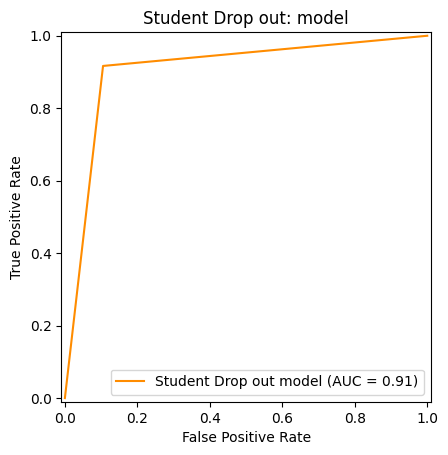

In [88]:
models_4, feature_importance_4 = hpo4.cross_validation_hpo(
    x=x4, y=y4,
    search_space=search_space, 
    folds=5,
    algo='rf'
    )
feature_importance_4

In [89]:
feature_importance_4

,Feature,Importance
4,no_passed_courses_3,0.313114
0,no_passed_courses_4,0.150000
12,no_passed_courses_1,0.143181
11,avg_grade_all_courses_2,0.100000
3,avg_grade_all_courses_4,0.082213
15,avg_grade_all_courses_1,0.076268
8,no_passed_courses_2,0.075791
7,avg_grade_all_courses_3,0.059433
1,no_of_failed_courses_4,0.000000
2,no_of_unattempted_courses_4,0.000000


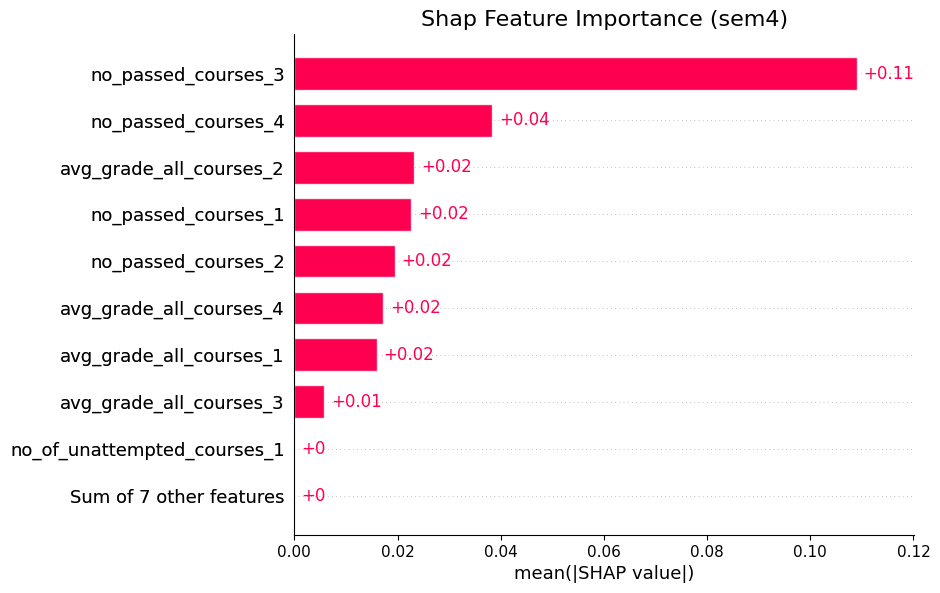

In [90]:
## Shap Global explainations
import shap
explainer4 = shap.TreeExplainer(models_4['model'], models_4['x_train'])
shap_values4 = explainer4(models_4['x_test'])

plt.title('Shap Feature Importance (sem4)', fontsize=16)
shap.plots.bar(shap_values4[..., 1])


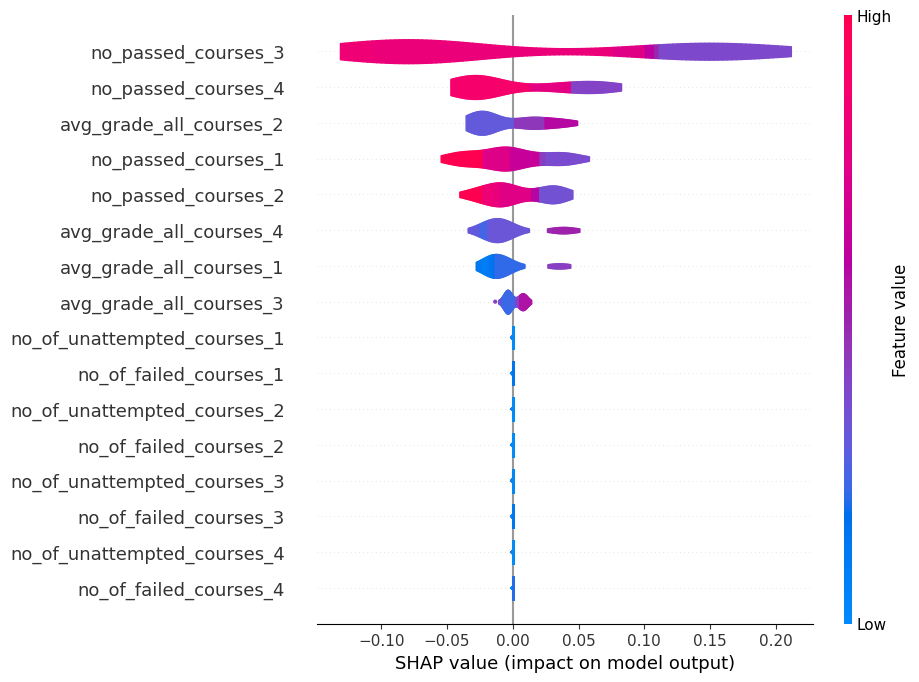

In [91]:
shap.plots.violin(shap_values4[..., 1], show=True)

In [92]:
## Local explainations
shap.initjs()
shap.force_plot(shap_values4[..., 1], link='identity')

In [93]:
hpo4.plot_shap_force(model=models_4, shap_values=shap_values4, student_index=1, link='identity', model_name='dt')

Student index 1 grades:
                             grades
no_passed_courses_4             5.0
no_of_failed_courses_4          0.0
no_of_unattempted_courses_4     0.0
avg_grade_all_courses_4         1.8
no_passed_courses_3             5.0
no_of_failed_courses_3          0.0
no_of_unattempted_courses_3     0.0
avg_grade_all_courses_3         1.9
no_passed_courses_2             5.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         1.8
no_passed_courses_1             4.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         1.5
Status: 0, Prediction: [0], Probability [0]: 0.721, Probability [1]: 0.279


In [94]:
hpo4.plot_shap_force(model=models_4, shap_values=shap_values4, student_index=3, link='identity', model_name='dt')


Student index 3 grades:
                             grades
no_passed_courses_4             1.0
no_of_failed_courses_4          0.0
no_of_unattempted_courses_4     0.0
avg_grade_all_courses_4         1.3
no_passed_courses_3             4.0
no_of_failed_courses_3          0.0
no_of_unattempted_courses_3     0.0
avg_grade_all_courses_3         1.8
no_passed_courses_2             4.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         1.3
no_passed_courses_1             3.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         2.0
Status: 0, Prediction: [0], Probability [0]: 0.628, Probability [1]: 0.372


In [95]:
hpo4.plot_shap_force(model=models_4, shap_values=shap_values4, student_index=17, link='identity', model_name='dt')

Student index 17 grades:
                             grades
no_passed_courses_4             4.0
no_of_failed_courses_4          0.0
no_of_unattempted_courses_4     0.0
avg_grade_all_courses_4         1.5
no_passed_courses_3             4.0
no_of_failed_courses_3          1.0
no_of_unattempted_courses_3     0.0
avg_grade_all_courses_3         3.2
no_passed_courses_2             5.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         1.7
no_passed_courses_1             5.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         1.9
Status: 0, Prediction: [0], Probability [0]: 0.712, Probability [1]: 0.288


In [96]:
hpo4.plot_shap_force(model=models_4, shap_values=shap_values4, student_index=27, link='identity', model_name='dt')

Student index 27 grades:
                             grades
no_passed_courses_4             0.0
no_of_failed_courses_4          0.0
no_of_unattempted_courses_4     6.0
avg_grade_all_courses_4         0.0
no_passed_courses_3             0.0
no_of_failed_courses_3          0.0
no_of_unattempted_courses_3     4.0
avg_grade_all_courses_3         0.0
no_passed_courses_2             0.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     6.0
avg_grade_all_courses_2         0.0
no_passed_courses_1             4.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         1.5
Status: 1, Prediction: [1], Probability [0]: 0.330, Probability [1]: 0.670
